<a href="https://colab.research.google.com/github/rajgupt/dl-notebooks/blob/main/pytorch/4_rnn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


[]


In [2]:

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('/content/drive/MyDrive/Colab Notebooks/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
import torch

In [37]:
def letterToIndex(letter):
  return all_letters.find(letter)


def letterToTensor(letter):
  t = torch.zeros(1,n_letters)
  t[0,letterToIndex(letter)] = 1
  return t

def lineToTensor(line):
  t = torch.zeros(len(line),1,n_letters)
  for i, l in enumerate(line):
    t[i][0][letterToIndex(l)] = 1
  return t

print(lineToTensor('AB'))

print(lineToTensor('AB').size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
torch.Size([2, 1, 57])


In [33]:
# define the RNN architecture 

from torch import nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size); # inp + hidden goes in 
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), dim=1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1,self.hidden_size)

n_hidden=128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [52]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [35]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [53]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Castillion
category = Japanese / line = Ino
category = Irish / line = Quigley
category = Czech / line = Merta
category = Italian / line = Leoni
category = Portuguese / line = Ferro
category = Polish / line = Lis
category = Arabic / line = Daher
category = Arabic / line = Handal
category = Italian / line = Robustelli


In [54]:
criterion = nn.NLLLoss()
learning_rate = 0.005 

In [55]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [63]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.7881 Khoury / French ✗ (Arabic)
10000 10% (0m 10s) 2.8498 Sulzbach / Irish ✗ (German)
15000 15% (0m 15s) 1.6295 O'Reilly / Irish ✓
20000 20% (0m 20s) 1.3561 Nowak / Polish ✓
25000 25% (0m 25s) 3.2251 O'Bree / French ✗ (Irish)
30000 30% (0m 30s) 1.8286 Toma / Japanese ✗ (Arabic)
35000 35% (0m 35s) 1.1208 Kim / Korean ✓
40000 40% (0m 40s) 0.1541 Rujenkov / Russian ✓
45000 45% (0m 45s) 0.3358 Scarsi / Italian ✓
50000 50% (0m 50s) 0.1286 Wawrzaszek / Polish ✓
55000 55% (0m 55s) 1.0921 Blecher / German ✓
60000 60% (1m 0s) 0.1948 Mui / Chinese ✓
65000 65% (1m 5s) 4.6754 Maly / English ✗ (Polish)
70000 70% (1m 10s) 0.1380 Raghailligh / Irish ✓
75000 75% (1m 15s) 0.1921 Papoutsis / Greek ✓
80000 80% (1m 20s) 2.2874 Clark / Czech ✗ (Scottish)
85000 85% (1m 25s) 0.1122 Najjar / Arabic ✓
90000 90% (1m 30s) 1.8921 Serafim / Polish ✗ (Portuguese)
95000 95% (1m 36s) 3.5784 Koch / Vietnamese ✗ (German)
100000 100% (1m 41s) 0.0256 O'Doherty / Irish ✓


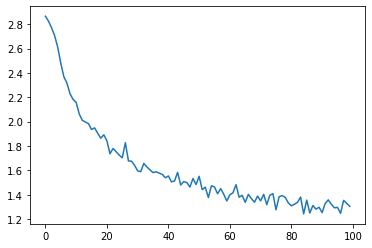

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)